In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import time 
# from tensorflow.keras.applications import *
# from matplotlib import plotly as plt
import matplotlib.pyplot as plt
import numpy as np

(30000, 56, 28)
(30000, 2)
(5000, 56, 28, 1)
(5000, 2)
(56, 28, 1)


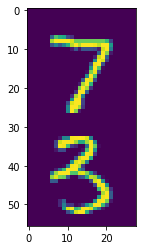

tf.Tensor(
[[7. 3.]
 [2. 9.]
 [1. 9.]
 ...
 [2. 4.]
 [4. 5.]
 [0. 6.]], shape=(5000, 2), dtype=float32)


In [100]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

N = x_train.shape[0] // 2
x_train = np.concatenate((x_train[:N], x_train[N:]), axis=1)
y_train = np.stack((y_train[:N], y_train[N:]), axis=1)
# y_train = tf.ones(y_train.shape)
N = x_test.shape[0] // 2

x_test = np.concatenate((x_test[:N], x_test[N:]), axis=1)
y_test = np.stack((y_test[:N], y_test[N:]), axis=1)
# y_test = tf.ones(y_test.shape)
print(x_train.shape)
print(y_train.shape)


input_shape = x_train[0].shape

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

x_test = tf.expand_dims(x_test, -1)
x_train = tf.expand_dims(x_train, -1)
print(x_test.shape)
print(y_test.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

input_shape = x_test[0].shape
num_classes = 10
print(input_shape)

plt.figure()
plt.imshow(x_test[0, :, :, 0]) 
plt.show()
print(y_test)

In [101]:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(20, activation="relu"),
        layers.Dense(2*num_classes, activation=None),
    ]
)

model.summary()


optimizer = tf.keras.optimizers.Adam(0.001)

cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# loss_fn = cce_loss
def loss_fn(y, y_hat): 
#     print(y[:, 0], y_hat[:, :10])
    return cce_loss(y[:, 0], y_hat[:, :10]) + cce_loss(y[:, 1], y_hat[:, 10:])

#         cce_loss(y_batch_train[:, 0], logits[:, :10]) + cce_loss(y_batch_train[:, 0], logits[:, 10:])



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 54, 26, 64)        640       
                                                                 
 conv2d_125 (Conv2D)         (None, 52, 24, 64)        36928     
                                                                 
 conv2d_126 (Conv2D)         (None, 50, 22, 32)        18464     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 25, 11, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_127 (Conv2D)         (None, 23, 9, 32)         9248      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 11, 4, 32)        0         
 g2D)                                                

In [102]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss_fn
)

model.fit(
    train_dataset,
    epochs=6,
    validation_data=test_dataset,
)

Epoch 1/6
938/938 [==============================] - 9s 9ms/step - loss: 0.6441 - val_loss: 0.1826
Epoch 2/6
938/938 [==============================] - 9s 9ms/step - loss: 0.1592 - val_loss: 0.1528
Epoch 3/6
938/938 [==============================] - 9s 9ms/step - loss: 0.1247 - val_loss: 0.2310
Epoch 4/6
938/938 [==============================] - 8s 9ms/step - loss: 0.0979 - val_loss: 0.1237
Epoch 5/6
938/938 [==============================] - 9s 9ms/step - loss: 0.0834 - val_loss: 0.1530
Epoch 6/6
938/938 [==============================] - 8s 9ms/step - loss: 0.0705 - val_loss: 0.1481


In [112]:

forward_pass_times = []
backward_pass_times = []

epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
#         print(y_batch_train[0])
#         plt.figure()
#         plt.imshow(x_batch_train[0, :, :, 0]) 
#         plt.show()       

        with tf.GradientTape() as tape:
    
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            loss_value = loss_fn(y_batch_train, logits)

#             loss_value = cce_loss(y_batch_train[:, 0], logits[:, :10]) + cce_loss(y_batch_train[:, 0], logits[:, 10:])

        grads = tape.gradient(loss_value, model.trainable_weights)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        if step > 100: 
            break

    print(f"Training loss (for one epoch): {float(loss_value)})")


Start of epoch 0
Training loss (for one epoch): 0.005868168082088232)

Start of epoch 1
Training loss (for one epoch): 0.0029710333328694105)

Start of epoch 2
Training loss (for one epoch): 0.3882928192615509)

Start of epoch 3
Training loss (for one epoch): 0.09082275629043579)

Start of epoch 4
Training loss (for one epoch): 0.00023428065469488502)

Start of epoch 5
Training loss (for one epoch): 0.014160487800836563)

Start of epoch 6
Training loss (for one epoch): 0.004273353610187769)

Start of epoch 7
Training loss (for one epoch): 0.0005908461171202362)

Start of epoch 8
Training loss (for one epoch): 0.24986019730567932)

Start of epoch 9
Training loss (for one epoch): 6.001183010084787e-06)


In [115]:
model.layers[0].name

'conv2d_124'

In [ ]:
n = 500

jac_dict = {}

"""
set up as:
{
  "layer_0": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]],
.
.
.
{
  "layer_k": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]]
} 
"""


def jacobian_f(weights, layer_name): 
    print(f'layer_name: {layer_name}')
#     print(f'weighst: {weights}')
    for i in range(n): 
        x = x_test[i:i+1]
        y = y_test[i:i+1]
        with tf.GradientTape() as t:
            logits = model(x) 
            cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            loss1 = cce_loss(y[:, 0], logits[:, :10]) 
        jac1 = t.jacobian(loss1, weights)

        with tf.GradientTape() as t:
            logits = model(x) 
            cce_loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            loss2 = cce_loss2(y[:, 1], logits[:, 10:])
        jac2 = t.jacobian(loss2, weights)
        
#         print(jac1[0].shape)
#         break
     
        jac_dict[name].append([tf.reshape(jac1[0], (-1, jac1[0].shape[-1])), tf.reshape(jac2[0], (-1, jac1[0].shape[-1]))])

#         if jac1 != None: 
#             print(jac1[0].shape)
#             print(tf.reshape(jac1[0], (-1, jac1[0].shape[-1])).shape)

for layer in model.layers: 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        jac_dict[name] = []
        jacobian_f(weights, name)

layer_name: conv2d_124
layer_name: conv2d_125
layer_name: conv2d_126


In [134]:
from sklearn.manifold import TSNE


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


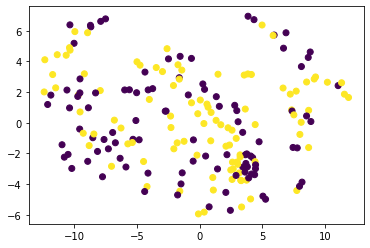

/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


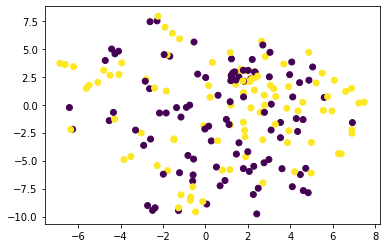

/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


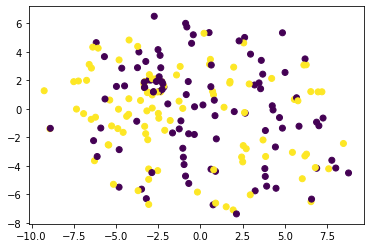

/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


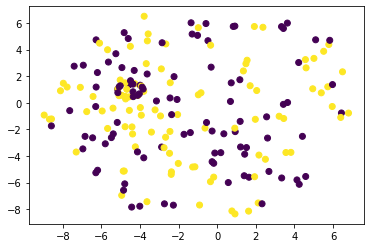

/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


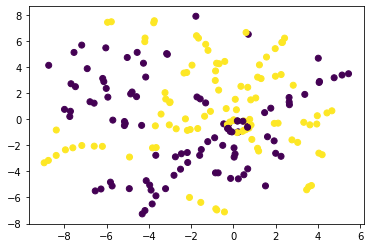

/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


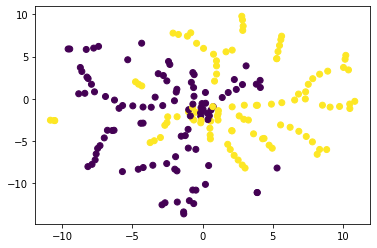

In [193]:
for layer in jac_dict.keys(): 
    grads = jac_dict[layer]

    X = np.array(grads)
    X = X.reshape(n, 2, -1)
    X = X.reshape(n*2, -1)

    X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X)
    
    labels = np.array([i % 2 for i in range(2*n)])
    plt.figure()
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = labels)
    plt.show()
    

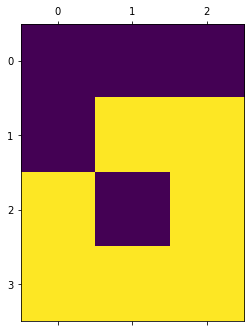

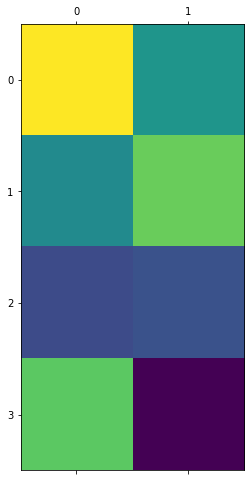

In [149]:


X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
plt.matshow(X)
plt.matshow(X_embedded)